Download the dataset

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf

# --- SETTINGS ---
ticker = "BTC-USD"
start  = "2022-06-30"        # wider window (safe)
end_inclusive = "2025-09-30" # target last day (inclusive)
save_dir = "/Users/utkarshtyagi/Documents/VSC/Dataset/"

# --- DOWNLOAD (make end inclusive by adding one day) ---
end_exclusive = (pd.to_datetime(end_inclusive) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
raw = yf.Ticker(ticker).history(start=start, end=end_exclusive, interval="1d", auto_adjust=False)

# Keep columns; bring index to column and drop tz for clean handling
raw = raw[["Open","High","Low","Close","Volume"]].reset_index()
raw["Date"] = pd.to_datetime(raw["Date"]).dt.tz_localize(None)

# --- SAVE FULL CSV with YY-MM-DD date string ---
full_path = os.path.join(save_dir, f"{ticker}_{start}_to_{end_inclusive}.csv")
df_out = raw.copy()
df_out["Date"] = df_out["Date"].dt.strftime("%y-%m-%d")
df_out = df_out[["Date","Open","High","Low","Close","Volume"]]
os.makedirs(save_dir, exist_ok=True)
df_out.to_csv(full_path, index=False)
print(f"Saved full dataset: {full_path}")

# ---------- TRAIN/TEST SPLIT (3 years train, 3 months test) ----------
end_date = pd.to_datetime(end_inclusive)

# Test starts on the FIRST day of the month that is 3 months before the month after end_date.
# Example: end=2025-09-30 -> test_start=2025-07-01
test_start = (end_date + pd.offsets.MonthBegin(1)) - pd.DateOffset(months=3)
test_end   = end_date

train_end   = test_start - pd.Timedelta(days=1)           # 2025-06-30
train_start = train_end - pd.DateOffset(years=3) + pd.Timedelta(days=1)  # 2022-07-01

# Clamp to available data just in case
data_min = raw["Date"].min()
if train_start < data_min:
    train_start = data_min

df_train = raw[(raw["Date"] >= train_start) & (raw["Date"] <= train_end)].copy()
df_test  = raw[(raw["Date"] >= test_start)  & (raw["Date"] <= test_end)].copy()

# Save train/test with YY-MM-DD format
def save_slice(df, path):
    tmp = df.copy()
    tmp["Date"] = tmp["Date"].dt.strftime("%y-%m-%d")
    tmp = tmp[["Date","Open","High","Low","Close","Volume"]]
    tmp.to_csv(path, index=False)

train_path = os.path.join(save_dir, f"{ticker}_TRAIN_{train_start.date()}_to_{train_end.date()}.csv")
test_path  = os.path.join(save_dir, f"{ticker}_TEST_{test_start.date()}_to_{test_end.date()}.csv")
save_slice(df_train, train_path)
save_slice(df_test,  test_path)
print(f"Saved train: {train_path}")
print(f"Saved test:  {test_path}")


Saved full dataset: /Users/utkarshtyagi/Documents/VSC/Dataset/BTC-USD_2022-06-30_to_2025-09-30.csv
Saved train: /Users/utkarshtyagi/Documents/VSC/Dataset/BTC-USD_TRAIN_2022-07-01_to_2025-06-30.csv
Saved test:  /Users/utkarshtyagi/Documents/VSC/Dataset/BTC-USD_TEST_2025-07-01_to_2025-09-30.csv


Sanity check

In [2]:
# ---------- SANITY CHECKS (applied to DataFrames directly) ----------
def sanity_check_df(df, expected_start, expected_end):
    """Quick integrity checks for daily crypto data."""
    dfc = df.sort_values("Date").reset_index(drop=True)
    cols = [c for c in ["Open","High","Low","Close","Adj Close","Volume"] if c in dfc.columns]

    print("\n--- Sanity Check ---")
    print("Rows:", len(dfc))
    print("Date range:", dfc["Date"].min().date(), "to", dfc["Date"].max().date())
    print("Duplicate dates:", dfc["Date"].duplicated().sum())

    # Coverage (expect all calendar days for BTC)
    full = pd.DataFrame({"Date": pd.date_range(expected_start, expected_end, freq="D")})
    miss = full.merge(dfc[["Date"]], on="Date", how="left", indicator=True)
    missing = miss.loc[miss["_merge"] == "left_only", "Date"]
    print("Missing calendar days (should be 0):", len(missing))
    if not missing.empty:
        print("First 10 missing:", [d.date() for d in missing.head(10)])

    # NA/Inf
    if cols:
        na_counts = dfc[cols].isna().sum()
        inf_counts = np.isinf(dfc[cols].to_numpy(dtype="float64")).sum()
    else:
        na_counts, inf_counts = pd.Series(dtype=int), 0
    print("\nNA counts by column:\n", na_counts)
    print("Any infinite values?:", bool(inf_counts))

    # Logical OHLC/Volume
    issues = {}
    if {"High","Low"}.issubset(dfc.columns):
        issues["high_ge_low"] = (~(dfc["High"] >= dfc["Low"])).sum()
        for m in [c for c in ["Open","Close","Adj Close"] if c in dfc.columns]:
            issues[f"{m}_within_low_high"] = (~((dfc[m] >= dfc["Low"]) & (dfc[m] <= dfc["High"]))).sum()
    if "Volume" in dfc.columns:
        issues["volume_non_negative"] = (dfc["Volume"] < 0).sum()
    print("\nLogical checks (violations):")
    for k, v in issues.items():
        print(f"  {k}: {v}")

    # Daily return diagnostics
    if "Close" in dfc.columns:
        dfc["pct_change_close"] = dfc["Close"].pct_change()
        print("\nClose pct-change summary (daily):")
        print(dfc["pct_change_close"].describe(percentiles=[0.01,0.05,0.95,0.99]))
        spikes = dfc.loc[dfc["pct_change_close"].abs() > 0.25, ["Date","Close","pct_change_close"]]
        print("Large daily moves > 25% (rows):", len(spikes))
        if not spikes.empty:
            print(spikes.head(10))

# Run sanity checks on both splits
sanity_check_df(df_train, train_start, train_end)
sanity_check_df(df_test,  test_start,  test_end)

# Quick summary for you
print("\n=== SPLIT SUMMARY ===")
print(f"Train period: {train_start.date()} to {train_end.date()}  | rows: {len(df_train)}")
print(f"Test  period: {test_start.date()} to {test_end.date()}    | rows: {len(df_test)}")


--- Sanity Check ---
Rows: 1096
Date range: 2022-07-01 to 2025-06-30
Duplicate dates: 0
Missing calendar days (should be 0): 0

NA counts by column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Any infinite values?: False

Logical checks (violations):
  high_ge_low: 0
  Open_within_low_high: 0
  Close_within_low_high: 0
  volume_non_negative: 0

Close pct-change summary (daily):
count    1095.000000
mean        0.001906
std         0.026074
min        -0.143490
1%         -0.063420
5%         -0.036356
50%        -0.000007
95%         0.045609
99%         0.090609
max         0.121443
Name: pct_change_close, dtype: float64
Large daily moves > 25% (rows): 0

--- Sanity Check ---
Rows: 92
Date range: 2025-07-01 to 2025-09-30
Duplicate dates: 0
Missing calendar days (should be 0): 0

NA counts by column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Any infinite values?: False

Logical checks (violations):
  high_ge_low: 0
  Open_w

EDA


=== Basic Summary of Close Prices (Train + Test) ===
count      1188.000000
mean      55734.162455
std       32597.772609
min       15787.284180
25%       26351.037109
50%       51018.460938
75%       84098.564453
max      123344.062500
Name: Close, dtype: float64

Date range: 2022-07-01 to 2025-09-30
Total days: 1187


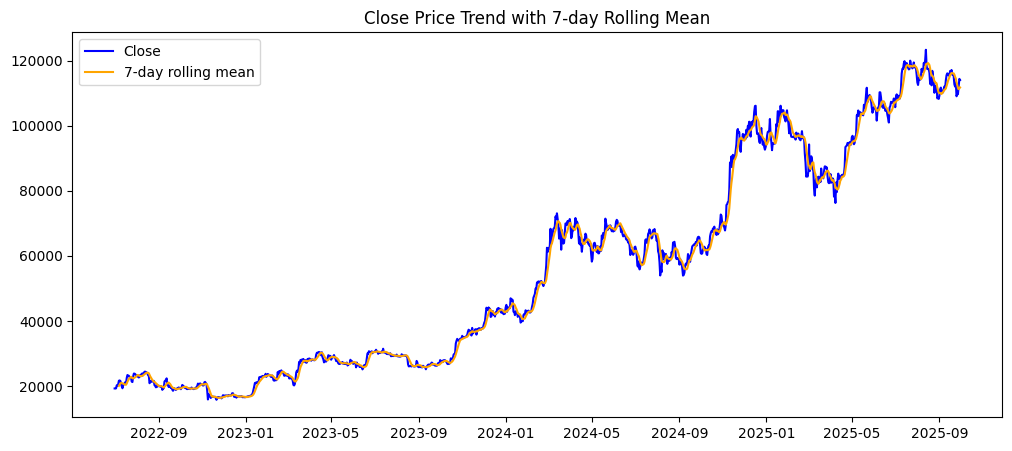

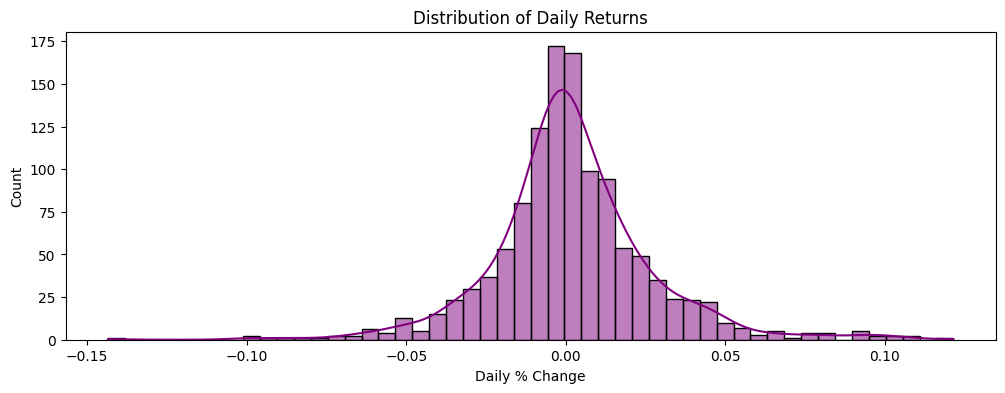


Daily return summary:
count    1187.000000
mean        0.001820
std         0.025401
min        -0.143490
1%         -0.062528
5%         -0.035795
50%        -0.000009
95%         0.044727
99%         0.083733
max         0.121443
Name: return, dtype: float64

=== Augmented Dickey-Fuller Test on Close ===
ADF Statistic: -0.0684
p-value: 0.9525
Critical Value (1%): -3.4359
Critical Value (5%): -2.8640
Critical Value (10%): -2.5681
Series is likely non-stationary (has trend/seasonality).


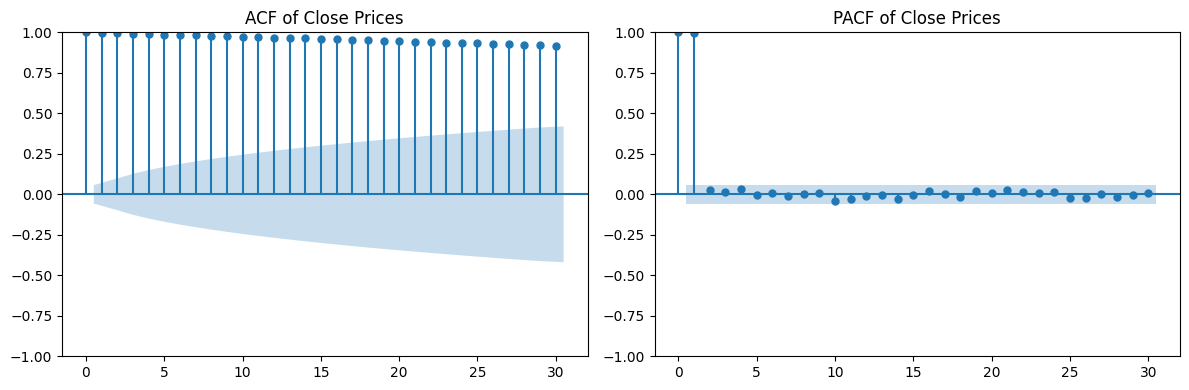


=== Augmented Dickey-Fuller Test on Returns ===
ADF Statistic: -35.7930
p-value: 0.0000
Returns are likely stationary (random-like).


In [11]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#  Summary and EDA on combined data
print("\n=== Basic Summary of Close Prices (Train + Test) ===")
df_all = pd.concat([df_train, df_test])
print(df_all["Close"].describe())

print(f"\nDate range: {df_all['Date'].min().date()} to {df_all['Date'].max().date()}")
print(f"Total days: {(df_all['Date'].max() - df_all['Date'].min()).days}")

# Trend & Seasonality Visualization 
plt.figure(figsize=(12,5))
plt.plot(df_all["Date"], df_all["Close"], label="Close", color="blue")
plt.plot(df_all["Date"], df_all["Close"].rolling(7).mean(), label="7-day rolling mean", color="orange")
plt.title("Close Price Trend with 7-day Rolling Mean")
plt.legend()
plt.show()

# Distribution & Daily Returns
df_all["return"] = df_all["Close"].pct_change()
plt.figure(figsize=(12,4))
sns.histplot(df_all["return"].dropna(), bins=50, kde=True, color="purple")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily % Change")
plt.show()

print("\nDaily return summary:")
print(df_all["return"].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

# Randomness / Stationarity Test
print("\n=== Augmented Dickey-Fuller Test on Close ===")
adf_result = adfuller(df_all["Close"].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("Series is likely stationary (rejects null of unit root).")
else:
    print("Series is likely non-stationary (has trend/seasonality).")

# Autocorrelation Structure
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df_all["Close"].dropna(), ax=ax[0], lags=30)
plot_pacf(df_all["Close"].dropna(), ax=ax[1], lags=30)
ax[0].set_title("ACF of Close Prices")
ax[1].set_title("PACF of Close Prices")
plt.tight_layout()
plt.show()

# Randomness / Stationarity Test on Returns
print("\n=== Augmented Dickey-Fuller Test on Returns ===")
adf_return = adfuller(df_all["return"].dropna())
print(f"ADF Statistic: {adf_return[0]:.4f}")
print(f"p-value: {adf_return[1]:.4f}")
if adf_return[1] < 0.05:
    print("Returns are likely stationary (random-like).")
else:
    print("Returns still show autocorrelation or trends.")

Methodology

Statistical Models

Detected season length: 7

Naive Model:
  MAE : 7366.9348
  RMSE: 8210.6967
  MAPE: 6.34%

Seasonal Naive Model:
  MAE : 7307.9402
  RMSE: 8184.5429
  MAPE: 6.29%

Trend (Drift) Naive Model:
  MAE : 4668.3323
  RMSE: 5807.2977
  MAPE: 4.01%

Seasonal + Trend Naive Model:
  MAE : 4623.5556
  RMSE: 5798.4415
  MAPE: 3.97%


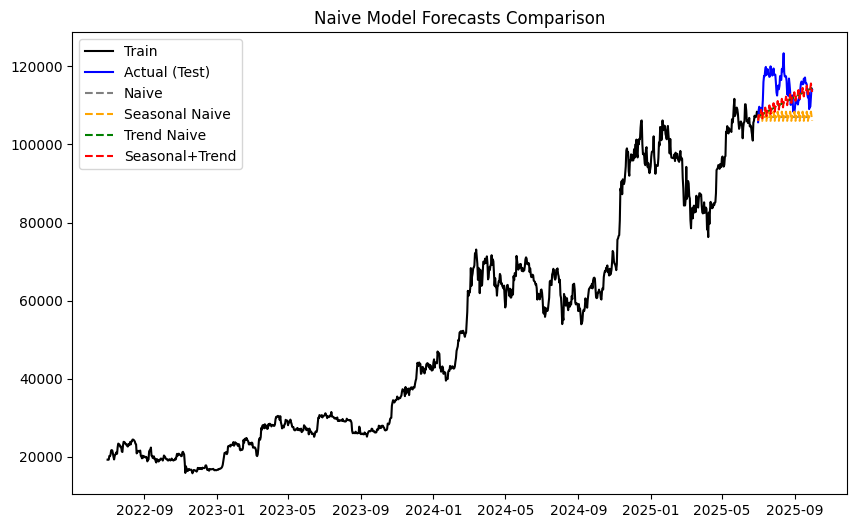

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Target column
target_col = "Close"

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_forecast(name, y_true, y_pred):
    print(f"\n{name} Model:")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"  RMSE: {rmse(y_true, y_pred):.4f}")
    print(f"  MAPE: {mape(y_true, y_pred):.2f}%")

def detect_season_length(df):
    freq = pd.infer_freq(df["Date"])
    if freq in ["D", "B"]:      # daily or business-daily
        return 7                # weekly seasonality
    elif freq in ["H"]:          # hourly data
        return 24               # daily seasonality
    elif freq in ["M"]:          # monthly
        return 12               # yearly seasonality
    else:
        print("Unknown frequency, defaulting to 7-day season.")
        return 7

# DETECT SEASONALITY
season_length = detect_season_length(df_train)
print(f"Detected season length: {season_length}")

# NAIVE 
naive_forecast = np.repeat(df_train[target_col].iloc[-1], len(df_test))

# SEASONAL NAIVE
seasonal_naive_forecast = df_train[target_col].iloc[-season_length:].tolist() * int(np.ceil(len(df_test)/season_length))
seasonal_naive_forecast = seasonal_naive_forecast[:len(df_test)]

# TREND NAIVE
y_first = df_train[target_col].iloc[0]
y_last  = df_train[target_col].iloc[-1]
n = len(df_train)
drift = (y_last - y_first) / (n - 1)
trend_naive_forecast = [y_last + drift * (i+1) for i in range(len(df_test))]

# SEASONAL + TREND NAIVE
seasonal_trend_forecast = [s + drift*(i+1) for i, s in enumerate(seasonal_naive_forecast)]

y_true = df_test[target_col].values

# Numpy arrays
naive_forecast_arr = np.array(naive_forecast)
seasonal_naive_forecast_arr = np.array(seasonal_naive_forecast)
trend_naive_forecast_arr = np.array(trend_naive_forecast)
seasonal_trend_forecast_arr = np.array(seasonal_trend_forecast)

evaluate_forecast("Naive", y_true, naive_forecast_arr)
evaluate_forecast("Seasonal Naive", y_true, seasonal_naive_forecast_arr)
evaluate_forecast("Trend (Drift) Naive", y_true, trend_naive_forecast_arr)
evaluate_forecast("Seasonal + Trend Naive", y_true, seasonal_trend_forecast_arr)

# VISUALIZE FORECASTS
plt.figure(figsize=(10,6))
plt.plot(df_train["Date"], df_train[target_col], label="Train", color="black")
plt.plot(df_test["Date"], y_true, label="Actual (Test)", color="blue")
plt.plot(df_test["Date"], naive_forecast_arr, label="Naive", linestyle="--", color="gray")
plt.plot(df_test["Date"], seasonal_naive_forecast_arr, label="Seasonal Naive", linestyle="--", color="orange")
plt.plot(df_test["Date"], trend_naive_forecast_arr, label="Trend Naive", linestyle="--", color="green")
plt.plot(df_test["Date"], seasonal_trend_forecast_arr, label="Seasonal+Trend", linestyle="--", color="red")
plt.legend()
plt.title("Naive Model Forecasts Comparison")
plt.show()

Machine Learning Models